# Parsing Experiment Results

In this notebook, we will be parsing the results of running `experiment.ipynb` from our `results` folder.

In [1]:
# configs
results_name = 'bench1_sleep_1000_200'
results_folder = './results/'
results_logger_glob = f'{results_folder}{results_name}/*_logger.csv'
results_reqs_glob = f'{results_folder}{results_name}/*_reqs.csv'

print(results_logger_glob)
print(results_reqs_glob)

./results/bench1_sleep_1000_200/*_logger.csv
./results/bench1_sleep_1000_200/*_reqs.csv


In [2]:
# plotting imports (needs to be before matplotlib)
import pacsltk.pacs_util as pacs_util
pacs_util.prepare_matplotlib_cycler()

# general imports
import os

# parsing imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# other seaborn aesthetic options: http://seaborn.pydata.org/tutorial/aesthetics.html
sns.set_style("whitegrid")

# for datetime analysis
from datetime import datetime, timedelta
import pytz

my_timezone = os.getenv('PY_TZ', 'America/Toronto')

# for file processing
import glob
import json

# for better printing of variables
from IPython.display import display

In [3]:
# utility functions

In [4]:
# Prepare for plots and make directories
figs_folder = "./figs/"
!mkdir -p {figs_folder}

def get_fig_path(x): return (os.path.join(figs_folder, "exp" +
              x + ".png"), os.path.join(figs_folder, "exp" + x + ".pdf"))

def tmp_fig_save(fig_name):
    paths = get_fig_path(fig_name)
    plt.savefig(paths[0], dpi=300)
    plt.savefig(paths[1])

def parse_epoch_cols(df, epoch_cols_list):
    for epoch_col in epoch_cols_list:
        times = df[epoch_col].apply(lambda x: datetime.fromtimestamp(x).astimezone(pytz.timezone(my_timezone)).replace(tzinfo=None))
        times = pd.to_datetime(times.dt.to_pydatetime())
        df[epoch_col + '_dt'] = times

# Developing Analysis of Logger Data

In [5]:
# get a list of logger files and sort them
logger_file_list = glob.glob(results_logger_glob)
logger_file_list.sort()

# logger_file_list

,ready_count,total_conc,conc_window_average,time,rps,cc,lambda_over_n
time_dt,,,,,,,
2021-01-25 14:46:56.502020,2,2,0.666667,1.611604e+09,1.0,1,0.5
2021-01-25 14:46:58.506002,2,0,0.672222,1.611604e+09,1.0,1,0.5
2021-01-25 14:47:00.506109,2,2,0.666667,1.611604e+09,1.0,1,0.5
2021-01-25 14:47:02.506127,2,1,0.675000,1.611604e+09,1.0,1,0.5
2021-01-25 14:47:04.516130,2,1,0.666667,1.611604e+09,1.0,1,0.5


<AxesSubplot:xlabel='time_dt'>

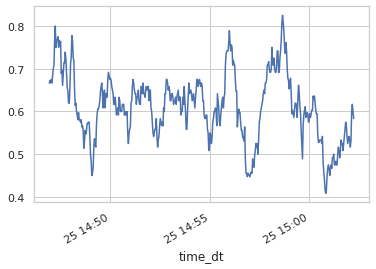

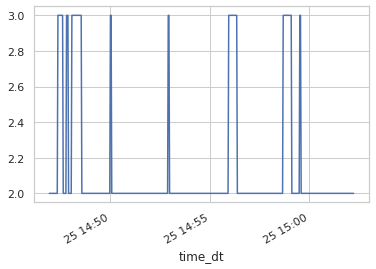

In [6]:
parse_skip_mins = 5

def parse_logger_file(csv_file_path):
    df = pd.read_csv(csv_file_path, index_col=0, parse_dates=True)
    parse_epoch_cols(df, ['time', ])
    # skip 5 minutes
    df = df[df['time_dt'] > df['time_dt'].min() + timedelta(minutes=parse_skip_mins)]
    df['lambda_over_n'] = df['rps'] / df['ready_count']
    # set index to the time
    df = df.set_index('time_dt')
    return df


df = parse_logger_file(logger_file_list[0])
display(df.head())

plt.figure()
df['conc_window_average'].plot()
plt.figure()
df['ready_count'].plot()

## Analyze Experiment-By-Experiment Results

100%|██████████| 9/9 [00:00<00:00, 65.49it/s]


,conc_window_average_mean,arrival_rate,average_ready_count,cc
0,0.610724,1.0,2.126362,1
1,0.674525,3.0,5.775330,1
2,0.686507,5.0,9.073171,1
3,0.688979,7.0,12.347345,1
4,0.694071,9.0,15.738359,1


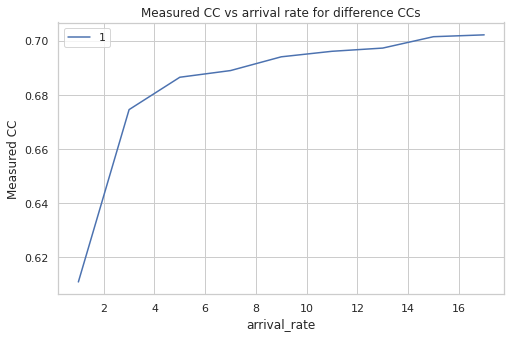

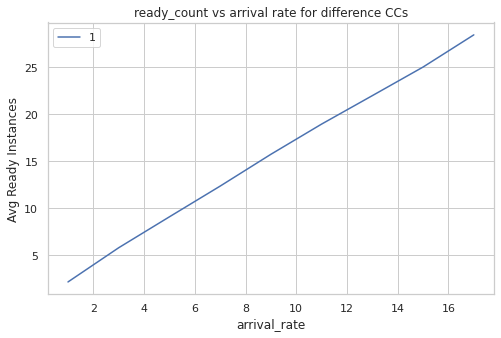

In [7]:
results_arr = []
for file_path in tqdm(logger_file_list):
    df = parse_logger_file(file_path)
    arrival_rate = df['rps'][0]
    cc = df['cc'][0]

    results_arr.append({
        'conc_window_average_mean': df['conc_window_average'].mean(),
        'arrival_rate': arrival_rate,
        'average_ready_count': df['ready_count'].mean(),
        'cc': cc,
    })

df_logger_result = pd.DataFrame(data=results_arr)
display(df_logger_result.head())

plt.figure(figsize=(8,5))
df_logger_result.set_index('arrival_rate').groupby('cc')['conc_window_average_mean'].plot()
plt.title('Measured CC vs arrival rate for difference CCs')
plt.ylabel('Measured CC')
plt.legend()
plt.figure(figsize=(8,5))
df_logger_result.set_index('arrival_rate').groupby('cc')['average_ready_count'].plot()
plt.title('ready_count vs arrival rate for difference CCs')
plt.ylabel('Avg Ready Instances')
plt.legend()

## Analyze Merged Results

100%|██████████| 9/9 [00:00<00:00, 54.76it/s]


,ready_count,total_conc,conc_window_average,time,rps,cc
lambda_over_n,,,,,,
0.333333,3.000000,1.258621,0.688362,1.611604e+09,1.000000,1.0
0.428571,7.000000,3.978261,0.712371,1.611606e+09,3.000000,1.0
0.454545,11.000000,3.000000,0.735000,1.611607e+09,5.000000,1.0
0.500000,4.454308,2.793734,0.644300,1.611605e+09,2.227154,1.0
0.529412,17.000000,10.588235,0.714798,1.611609e+09,9.000000,1.0


Text(0, 0.5, 'measured concurrency')

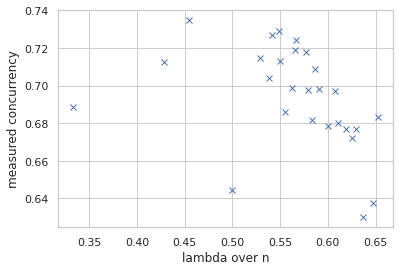

In [8]:
df_logger_merged = pd.DataFrame()
for file_path in tqdm(logger_file_list):
    df = parse_logger_file(file_path)
    df_logger_merged = df_logger_merged.append(df)


tmpdf = df_logger_merged.groupby('lambda_over_n').mean()
display(tmpdf.head())
# let's analyze the relationship between conc_window_average and lambda_over_n
plt.plot(tmpdf.index, tmpdf['conc_window_average'], 'x')
plt.xlabel('lambda over n')
plt.ylabel('measured concurrency')

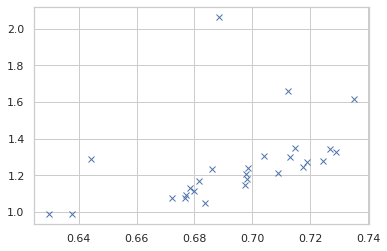

In [9]:
# this tries to model average service time as a function of average number of requests in each container
plt.plot(tmpdf['conc_window_average'], tmpdf['conc_window_average'] / tmpdf.index, 'x')

Now, let's try and see we can see any relationship between $\lambda/N$ and the $\mu$ and $\sigma$ of the measured concurrency.

In [10]:
tmp_res = []
for lambda_over_n in df_logger_merged['lambda_over_n'].unique():
    sub_df = df_logger_merged.loc[df_logger_merged['lambda_over_n'] == lambda_over_n, :]
    if len(sub_df) > 10:
        tmp_res.append({
            'lambda_over_n': lambda_over_n,
            'conc_window_average_mean': np.mean(sub_df['conc_window_average']),
            'conc_window_average_std': np.std(sub_df['conc_window_average']),
        })
    # if len(sub_df) > 400:
    #     plt.figure()
    #     plt.hist(sub_df['conc_window_average'], bins=20)

tmpdf = pd.DataFrame(data=tmp_res)

average std to mean 0.0409915057443876


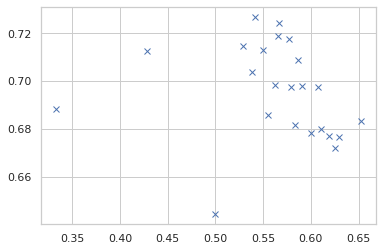

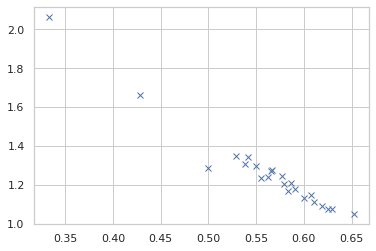

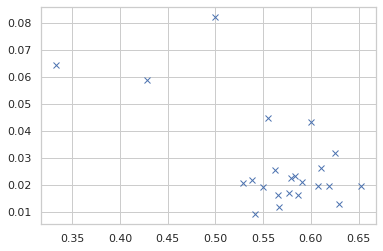

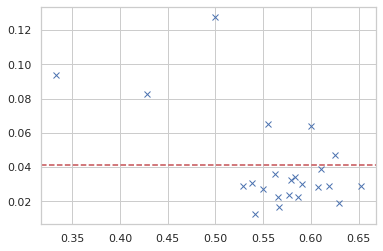

In [11]:
conc_avg_std_to_mean = (tmpdf['conc_window_average_std'] / tmpdf['conc_window_average_mean']).mean()
print("average std to mean", conc_avg_std_to_mean)

plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_mean'], 'x')
plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_mean'] / tmpdf['lambda_over_n'], 'x')
plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_std'], 'x')
plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_std'] / tmpdf['conc_window_average_mean'], 'x')
plt.axhline(y=conc_avg_std_to_mean, c='r', ls='--')

# Developing Analysis of Requests Results

In [12]:
reqs_file_list = glob.glob(results_reqs_glob)
reqs_file_list.sort()

,client_start_time,client_end_time,client_elapsed_time,start_conc,end_conc,success,start_ready_count,end_ready_count,rps,cc,client_end_time_dt,lambda_over_n
client_start_time_dt,,,,,,,,,,,,
2021-01-25 14:46:55.821754,1.611604e+09,1.611604e+09,1.055574,2,1,True,2,2,1.0,1,2021-01-25 14:46:56.877328,0.5
2021-01-25 14:46:57.241313,1.611604e+09,1.611604e+09,1.185715,1,1,True,2,2,1.0,1,2021-01-25 14:46:58.427028,0.5
2021-01-25 14:46:59.774093,1.611604e+09,1.611604e+09,1.165855,1,2,True,2,2,1.0,1,2021-01-25 14:47:00.939948,0.5
2021-01-25 14:47:00.319069,1.611604e+09,1.611604e+09,1.257557,2,1,True,2,2,1.0,1,2021-01-25 14:47:01.576626,0.5
2021-01-25 14:47:02.177324,1.611604e+09,1.611604e+09,1.053083,1,1,True,2,2,1.0,1,2021-01-25 14:47:03.230407,0.5


<AxesSubplot:xlabel='client_start_time_dt'>

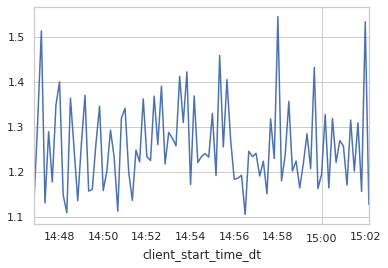

In [13]:
def parse_reqs_file(csv_file_path):
    df = pd.read_csv(csv_file_path, index_col=0, parse_dates=True)
    parse_epoch_cols(df, ['client_start_time', 'client_end_time' ])
    # skip 5 minutes
    df = df[df['client_start_time_dt'] > df['client_start_time_dt'].min() + timedelta(minutes=parse_skip_mins)]
    df['lambda_over_n'] = df['rps'] / df['start_ready_count']
    # # set index to the time
    df = df.set_index('client_start_time_dt')
    return df


df = parse_reqs_file(reqs_file_list[0])
display(df.head())

plt.figure()
df['client_elapsed_time'].resample('10s').mean().plot()

## Analyze Experiment-By-Experiment Results

In [14]:
results_arr = []
for file_path in tqdm(reqs_file_list):
    df = parse_reqs_file(file_path)
    arrival_rate = df['rps'][0]
    cc = df['cc'][0]

    results_arr.append({
        'arrival_rate': arrival_rate,
        'average_resp_time': df['client_elapsed_time'].mean(),
        'average_ready_count': df['start_ready_count'].mean(),
        'lambda_over_n': df['lambda_over_n'].mean(),
        'cc': cc,
    })

df_reqs_result = pd.DataFrame(data=results_arr)
display(df_reqs_result.head())


100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


,arrival_rate,average_resp_time,average_ready_count,lambda_over_n,cc
0,1.0,1.274576,2.117517,0.480414,1
1,3.0,1.236933,5.779558,0.525168,1
2,5.0,1.229565,9.075323,0.553567,1
3,7.0,1.210237,12.337799,0.568275,1
4,9.0,1.202168,15.722419,0.573373,1


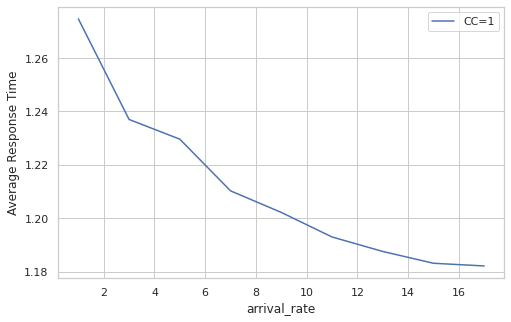

In [15]:
# plt.plot(df_reqs_result['arrival_rate'], df_reqs_result['average_resp_time'])
# relationship between arrival rate and response time
plt.figure(figsize=(8,5))
for cc in df_reqs_result['cc'].unique():
    sub_df = df_reqs_result[df_reqs_result['cc'] == cc]
    tmpdf = sub_df.set_index('arrival_rate')
    tmpdf['average_resp_time'].plot(label=f"CC={cc}")
    
plt.ylabel('Average Response Time')
plt.legend()

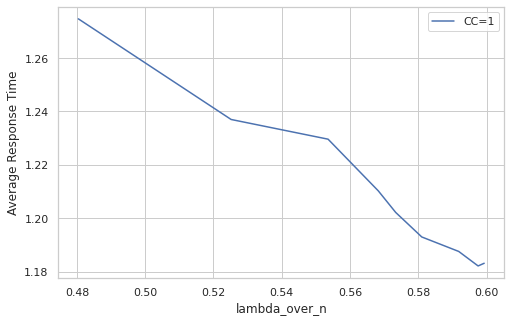

In [16]:
# check for relationships between lambda/N and average response time
plt.figure(figsize=(8,5))
for cc in df_reqs_result['cc'].unique():
    tmpdf = df_reqs_result[df_reqs_result['cc'] == cc]
    tmpdf.groupby('lambda_over_n').mean()['average_resp_time'].plot(label=f"CC={cc}")
    
plt.ylabel('Average Response Time')
plt.legend()

## Analyze Merged Results

In [17]:
df_reqs_merged = pd.DataFrame()
for file_path in tqdm(reqs_file_list):
    df = parse_reqs_file(file_path)
    df_reqs_merged = df_reqs_merged.append(df)


tmpdf = df_reqs_merged.groupby('lambda_over_n').mean()
display(tmpdf.head())

100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


,client_start_time,client_end_time,client_elapsed_time,start_conc,end_conc,success,start_ready_count,end_ready_count,rps,cc
lambda_over_n,,,,,,,,,,
0.333333,1.611604e+09,1.611604e+09,1.199301,2.169811,2.226415,True,3.000000,2.896226,1.000000,1.0
0.428571,1.611606e+09,1.611606e+09,1.224665,4.921824,5.130293,True,7.000000,6.908795,3.000000,1.0
0.454545,1.611607e+09,1.611607e+09,1.192452,3.666667,6.666667,True,11.000000,10.000000,5.000000,1.0
0.500000,1.611606e+09,1.611606e+09,1.235276,4.910761,4.888889,True,6.305628,6.294255,3.152814,1.0
0.529412,1.611609e+09,1.611609e+09,1.188795,11.498258,11.495935,True,17.000000,16.937282,9.000000,1.0


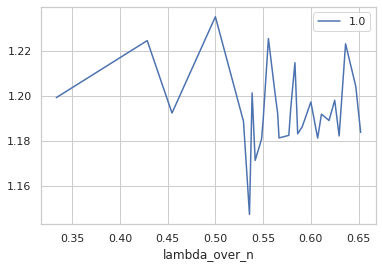

In [18]:
tmpdf.groupby('cc')['client_elapsed_time'].plot()
plt.legend()

,lambda_over_n,resp_time_avg
0,0.500000,1.235276
1,0.333333,1.199301
2,0.600000,1.197344
3,0.428571,1.224665
4,0.555556,1.225554


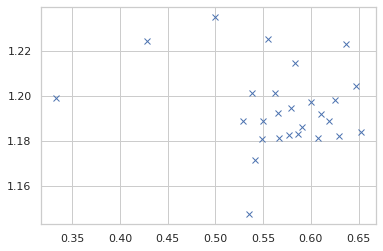

In [19]:
tmp_res = []
for lambda_over_n in df_reqs_merged['lambda_over_n'].unique():
    sub_df = df_reqs_merged.loc[df_reqs_merged['lambda_over_n'] == lambda_over_n, :]
    if len(sub_df) > 10:
        tmp_res.append({
            'lambda_over_n': lambda_over_n,
            'resp_time_avg': np.mean(sub_df['client_elapsed_time']),
        })

tmpdf = pd.DataFrame(data=tmp_res)
display(tmpdf.head())

plt.plot(tmpdf['lambda_over_n'], tmpdf['resp_time_avg'], 'x')